In [ ]:
import matplotlib.pyplot as plt
import env.guide_sim as gs
import params
import torch
import torchvision.transforms as transforms
import matplotlib
from matplotlib import animation
import random
import os

pygame-ce 2.5.0 (SDL 2.30.3, Python 3.10.0)


In [ ]:
def display_video(frames:list, framerate:int=30, dpi:int=70):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

## 加载导丝仿真环境

In [2]:
dataset_path = "datas/exvivo/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]
env = gs.GuidewireEnv(tasks[0])

## 尝试加载导丝环境

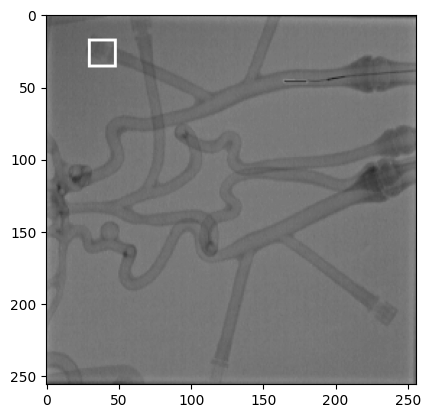

In [3]:
img = env.reset()  # 重置环境（每次要开始交互之前必须这么做）（输入代表根据序号开启某个任务）
plt.imshow(img[0], cmap='gray')

## 图片做域随机化处理


In [4]:
# 定义转换管道，包括域随机化
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机改变颜色属性
    transforms.RandomResizedCrop(size= (256, 256), scale=(0.95, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomRotation(degrees=2),  # 随机旋转
])


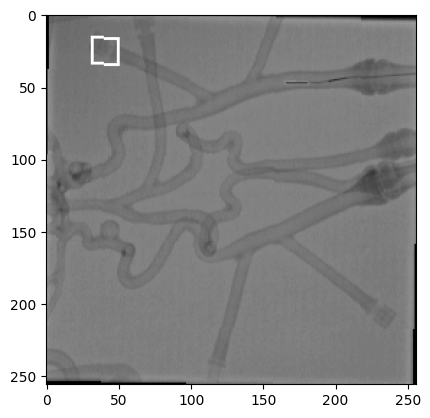

In [5]:
tensor = torch.from_numpy(img)
tensor = transform(tensor)
tensor.shape
plt.imshow(tensor[0], cmap='gray')

## 尝试交互 (往前推进十次)

0 0.4430379746835443 False 0
1 -0.43512658227848106 False 1
2 -0.43512658227848106 False 1
3 0.34810126582278483 False 0
4 -0.43512658227848106 False 1
5 -0.43512658227848106 False 1
6 0.0 False 1
7 0.0 False 1
8 0.34810126582278483 False 0
9 0.34810126582278483 False 0
10 0.34810126582278483 False 0
11 -0.43512658227848106 False 1
12 -0.43512658227848106 False 1
13 0.34810126582278483 False 0
14 -0.43512658227848106 False 1
15 -0.43512658227848106 False 1
16 0.0 False 1
17 0.34810126582278483 False 0
18 0.34810126582278483 False 0
19 -0.43512658227848106 False 1
20 0.34810126582278483 False 0
21 -0.43512658227848106 False 1
22 -0.43512658227848106 False 1
23 0.34810126582278483 False 0
24 0.34810126582278483 False 0
25 0.34810126582278483 False 0
26 0.34810126582278483 False 0
27 0.34810126582278483 False 0
28 -0.43512658227848106 False 1
29 0.34810126582278483 False 0
30 0.34810126582278483 False 0
31 0.569620253164557 False 0
32 0.4430379746835443 False 0
33 -0.5537974683544303 Fals

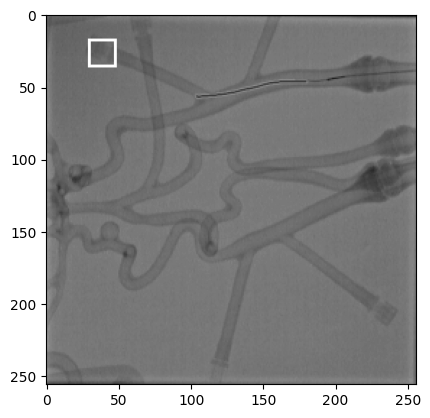

In [8]:
env.reset()
for i in range(100):
    action = random.choice([0, 1])
    img, reward, is_done, _ = env.step(action)  # 执行一个动作（0: 推进， 1： 撤回， 2，3：旋转）
    print(i, reward, is_done, action)
    if is_done:
        break
plt.imshow(img[0], cmap='gray') 
print(env.inial_a_star, env.last_a_star)

In [3]:
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

env.get_now_tip_pos(), env.metadata.target_pos

NameError: name 'env' is not defined

In [ ]:

import sys
# 全局定义训练环境
import matplotlib.pyplot as plt
import numpy as np 
from tqdm.notebook import tqdm
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib_inline import backend_inline
from IPython.display import HTML, clear_output
import os
backend_inline.set_matplotlib_formats('svg')
def display_video(frames:list, framerate:int=30, dpi:int=70):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

我们的目标是训练一个AI，能够根据图像输入学习到将导丝推送到目标位置（白框）

In [ ]:
from agents.ppo import Agent, ReplayData, ExperimentReplayBuffer
from networks.vit import VIT3_FC
from env.metadata import GuideSimMetadata, HyperParams
model = VIT3_FC()
count = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {count}")
agent = Agent(model)
agent.ac_model = model.to(agent.device)
hyper = HyperParams()
hyper.load_from_json("./hyper.json")
agent.set_hyperpara(hyper)
agent.plot_attrs()

## 需要尽可能的提升增加泛化性

这个仿真器提供了多种不同的任务，包括不同形状和大小的目标，不同难度的背景，不同难度的导丝路径

## 尝试使用Qwen2.5VL


In [70]:
from agents.qwen_vl import Agent

In [71]:
openai_api_key = "EMPTY"
openai_api_base = "http://192.168.1.110:1234/v1"
model="qwen2.5-vl-7b-instruct"
agent = Agent(openai_api_key, openai_api_base, model)

In [72]:
chat_response = agent.chat_with_array(img[0],
                    "将导丝递送到白框位置，你可以推进，后退，左转和右转，请输出你认为的导丝动作选择")  # 与agent对话
plt.imshow(img[0], cmap='gray')

APIConnectionError: Connection error.

In [18]:
chat_response.choices[0].message.content  # 获取回复内容

'根据图像显示的信息，导丝已经到达了白框的位置。因此，在这种情况下，不需要进行任何操作来移动或调整导丝。导丝已经在目标位置，可以保持不动。\n\n所以，正确的答案是：无需进行任何操作（即“静止”）。'

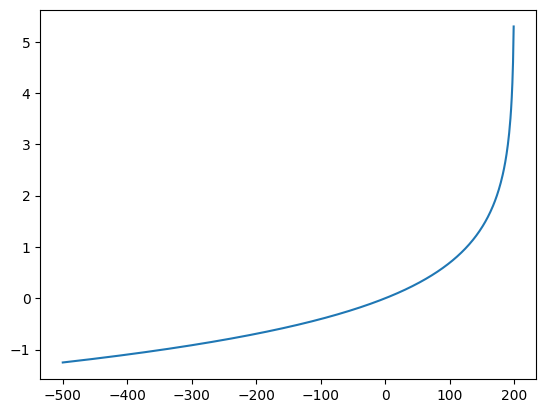

In [ ]:
import math
import numpy as np

def f(x):
    return np.log((200)) - np.log((-x + 200))
x = np.arange(-500, 200, 1)

plt.plot(x, f(x))


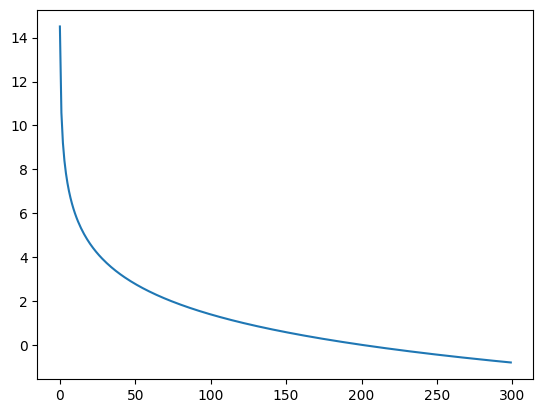

In [99]:
import numpy as np

def merged_formula(x):
    return np.log(200 / (( x ** 2 / 200 ) + 0.0001))

# x变为距离
x = np.arange(0, 300, 1)
plt.plot(x, merged_formula(x))

In [109]:
merged_formula(40)

3.218863324946325